<a href="https://colab.research.google.com/github/jesperiksson/struc-mon/blob/master/Struc_mon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data source
Specify the source of the data to be used

In [362]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings
There are mainly three cells which control the program
## Main Settings - make adjustments here
The `use` variable decides weather to use a MLP-model or a LSTM-model.
The `name` variable sets the name of the variable which will be used when saving models, architectures and figures.
The `retrain` variable tells the program weather it should initiate a new training process even though there is a trained model with that name.
The `overwrite` variable tells the program weather it should load the same `architecture` dictionary as was used when the model was created. If any changes are to be made this must be set to `True`.
If `architecture_mode` is set to `2` all the settings above can be overrided for each model that is used.  

In [363]:
use = 'MLP'
name = 'placeholder'
retrain = False
overwrite = True
train_process = 'entire_set'
'''
'entire_set' - fit all data into X and Y
'batch by batch' - fit a series into X and Y, train, fit next series into X and Y, train, repeat
'generator' - keep generating sample after sample, working through all available data
'''
architecture_mode = 2
'''
mode = 1 : Uses the architecture specified only
mode = 2 : Uses several architectures specified below
'''
eval_mode = 2
'''
mode = 1: evaluation()
mode = 2: batch_evaluation()
'''
dataset = 4
'''
dataset 1 - Random speeds
dataset 2 - Same speeds for all damage cases plus extra speeds for healthy
dataset 3 - dataset 2 with extra healthy
dataset 4 - dataset 1 with extra healthy
'''
save_plots = True

This function handles the implications of the `retrain` setting. 

In [364]:
def setup(use, name, retrain, overwrite, base_model = None):
    setup_dict = {
        'use' : use,
        'name' : name,
        'dataset' : dataset, # 1 # our_measurements, 2: our_measurements3
        'retrain' : retrain, # Loads the model to train it further, the original model is untouched
        'appendix' : 'v2',
        'overwrite' : overwrite
    }
    if setup_dict['retrain'] == True:
        setup_dict.update({
            'base_model' : base_model, # if retrain is True, this is the model to be loaded
        })
        setup_dict.update({
            'fname' : setup_dict['use'] + setup_dict['name'],
            'fname_base' : setup_dict['use'] + setup_dict['base_model']  
        })
        setup_dict.update({
            'fpath' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/' + setup_dict['fname'] + '.pkl',
            'fpath_base' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/' + setup_dict['fname_base'] + '.pkl'  
        })
    elif setup_dict['retrain'] == False:
        setup_dict.update({
            'fname' : setup_dict['use'] + setup_dict['name'],
            'fname_base' : setup_dict['use'] + setup_dict['name']
        })
        setup_dict.update({
            'fpath' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/' + setup_dict['fname'] + '.pkl',
            'fpath_base' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/' + setup_dict['fname'] + '.pkl',  
        })
        
    return setup_dict
#setup_dict = setup('LSTM')

### Import function

In [365]:
import pickle
def load_architecture(setup_dict):
    with open(setup_dict['fpath'], 'rb') as f:
        return pickle.load(f) 

### Save function

In [366]:
def save_architecture(arch):
    with open(arch['model_path']+ arch['fname'] +'.pkl', 'wb') as f:
        pickle.dump(arch, f, pickle.HIGHEST_PROTOCOL)

Use this function to inspect an already existing model

In [367]:

def inspect(name, use):
    d = {'fpath' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/'+use+name+'.pkl'}
    arch = load_architecture(d)
    return arch
inspect(name = 'riodejaneiro1_4', use = 'LSTM')

{'Dense_activation': 'tanh',
 'active_sensors': ['90'],
 'appendix': 'v2',
 'batch_size': 16,
 'bias': True,
 'confusion_matrices': {'cdf': 'CDF', 'poly': 'Polynomial approximation'},
 'data_path': '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/dataset4/e90/',
 'data_split': {'test': 50, 'train': 30, 'validation': 20},
 'dataset': 4,
 'delta': 1,
 'dropout_rate': 0.2,
 'early_stopping': True,
 'epochs': 200,
 'eval_batch_size': 32,
 'features': 1,
 'fitting_points': 20,
 'fname': 'LSTMriodejaneiro1_4',
 'fname_base': 'LSTMriodejaneiro1_4',
 'foi': 'normalization',
 'fpath': '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/LSTMriodejaneiro1_4.pkl',
 'fpath_base': '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/LSTMriodejaneiro1_4.pkl',
 'from': 0,
 'learning_rate': 0.001,
 'loss': 'mse',
 'loss_path': '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/loss/',
 'metric': 'rmse',
 'min_delta': 0.0001,
 'mode': '2',
 'model': '

## Architecture
The `architecture` dictionary is where the program is controlled from. All the settings are made here.
Some entries that need further explanation:

`'model'`- Specifies which `Keras.model` object to use. There are a bunch already implemented.
    How to implement a new function:
        1. Add a cell below "Models" and create a function that makes the desired model in the same way as the already implemented functions
        2. Add the function to the `model_dict` in the `__init__()` function of the `ǸeuralNet` class.
        3. Chose the respective keys as the value for the `model` key in `architecture`

`preprocess_type` - Specifies which type of preprocessing to apply on the data. 
    `data` - No preprocess is made, all timesteps are kept
    `peaks` - Only peak values and their timesteps are kept
    
`Normalization` - Specifies which normalization to apply on the data.
    `Maximum` - All accelerations are subtracted by the mean and divided by the maximum.
    `L-1` - All accelerations are subtracted by the mean and divided by the L-1 norm. 
    `L-2` - All accelerations are subtracted by the mean and divided by the L-2 norm.
    `Raw data` - No normalization is made
    
`loss`, `metric`, `val_loss` - Specifies the loss function and any further metrics. See https://keras.io/api/metrics/ for more info. 

`shuffle` - Weahter to shuffle the samples in a batch during the training process. 

In [368]:
def get_arch(setup_dict, changes = {}):
    architecture = None 
    if setup_dict['overwrite'] == False:
        try:
            architecture = load_architecture(setup_dict)
            print('Loaded architecture: ', setup_dict['fname'])
            new_model = False
        except IOError: 
            new_model = True
    elif setup_dict['overwrite'] == True:    
        new_model = True
    if new_model == True:
        architecture = setup_dict
        architecture.update({
            'active_sensors' : ['90'],
            'predict' : 'accelerations', # accelerations or damage
            # Paths
            'data_path'       : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/dataset'+str(architecture['dataset'])+'/e90/',
            'model_path'      : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/models/',
            'plot_path'       : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/plots/',
            'series_plot_path': '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/plots/series/',
            'model_plot_path' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/model_plots/',
            'loss_path'       : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/loss/',
            'prediction_path' : '/content/drive/My Drive/KTH/Examensarbete/struc-mon (kopia)/prediction/'
            })
        sensor_dict = {}
        for i in range(len(architecture['active_sensors'])):
            sensor_dict.update({
                architecture['active_sensors'][i] : i
                })
        architecture.update({
            'sensors' : sensor_dict
            })
        architecture.update({
            'model' : 'Single layer MLP',
            # Net configuaration
            'n_units' : {
                'first' : 100, 
                'second' : 75, 
                'third' : 45, 
                'fourth' : 20
                },
            'bias' : True,
            'n_pattern_steps' : 100, # Kan ändras
            'n_target_steps' : 20,
            'pattern_delta' : 1,
            # Sensor parameters
            'pattern_sensors' : ['90'],
            'target_sensor' : '90',
            'target_sensors' : ['90'],
            # Training parameters
            'batch_size' : 16,
            'positions' : False,
            'data_split' : {
                'train':30, 
                'validation':20, 
                'test':50
                }, # sorting of data 
            'delta' : 1, # Kan ändras
            'Dense_activation' : 'tanh',
            'early_stopping' : True,
            'epochs' : 200,
            'learning_rate' : 0.001, # 0.001 by default
            'min_delta' : 0.0001,
            'preprocess_type' : 'data',
            'patience' : 10,
            'shuffle' : True,
            'steps_per_epoch' : 100,
            'validation_steps' : 50,
            'dropout_rate' : 0.2, # Only in use if model utilizes dropout
            # Loss function
            'loss' : 'mse',
            'metric': 'rmse',
            'val_loss' : 'val_loss',
            # Data
            'normalization' : 'L-2',
            'speed_unit' : 'km/h',
            'seed' : 3,
            'mode' : '2', # 1 - , 2- 
            'from' : 0,
            'to' : -1,
            'random_mode' : 'debug', # test or debug
            # Noise
            'noise' : False,
            'noise_mean' : 0,
            'noise_var' : 0.001,
            # Evaluation parameters
            'eval_batch_size' : 32,
            # Model saving
            'save_periodically' : False,
            'save_interval' : 10, # Number of series to train on before saving
            'foi' : 'normalization', # feature of interest, the one to be printed in the title of plots
            # Classification
            'probability_limit' : 0.90,
            'fitting_points' : 20,
            'z-score' : 2.2,
            'confusion_matrices' : {
                'cdf' : 'CDF',
                'poly' : 'Polynomial approximation'
                },
            'poly_deg' : 1
        })
        architecture.update({
            'features' : len(architecture['pattern_sensors']) + architecture['positions']
        })
        architecture.update(changes)
        save_architecture(architecture)
    return architecture
#check_if_existing(setup(use,name,retrain,overwrite))

In [369]:
image = 0

# Mode 2
if `architecture_mode` is set to 2, i.e. several models are loaded at once the piece of code below is executed. In order to add models, add entries in the `architectures` dictionary. 




In [370]:

architecture = get_arch(setup(use,name,retrain,overwrite))
if architecture_mode == 2:
    rt = False
    ow = True
    name1 = 'oslo'
    name2 = 'copenhagen'
    architectures = {
        '1' : get_arch(setup(use = 'MLP', name = name1+'1_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Single layer MLP'}),
        '2' : get_arch(setup(use = 'MLP', name = name1+'2_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Two layer MLP'}),
        '3' : get_arch(setup(use = 'MLP', name = name1+'3_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Three layer MLP'}),
        '4' : get_arch(setup(use = 'MLP', name = name1+'4_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Four layer MLP'}),
        '5' : get_arch(setup(use = 'LSTM', name = name2+'1_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Single layer LSTM'})
        '6' : get_arch(setup(use = 'LSTM', name = name2+'2_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Two layer LSTM'}),
        '7' : get_arch(setup(use = 'LSTM', name = name2+'3_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Three layer LSTM'}),
        '8' : get_arch(setup(use = 'LSTM', name = name2+'4_'+str(dataset), retrain = rt, overwrite = ow), changes = {'model' : 'Four layer LSTM'}),
    }
    arch_keys = list(architectures.keys())

# Import function
This function creates instances of the `DataBatch` class, where each batch contains one data series, a.k.a one passage. There are subclasses `data`, `peaks`, `extrema` and `frequency`. Data contains the entire series, peaks contains all peak accelerations, extrema contains all local and global extreme values and frquency contains a frequency spectrum. 

In [371]:
import os
import random
import numpy as np
import h5py
import scipy as sp
import scipy.signal
def fit_to_NN(
        data_split, 
        path, 
        healthy_percentage, 
        arch):
    
    types = arch['preprocess_type']
    paths = {}

    for i in range(len(arch['active_sensors'])):
        paths.update(
            {arch['active_sensors'][i] : path+'s'+arch['active_sensors'][i]+'/'})
    if arch['random_mode'] == 'debug':
        seed = arch['seed']
    elif arch['random_mode'] == 'test':
        seed = random.randint(0,10000)
    file_list = os.listdir(paths[arch['active_sensors'][0]])
    file_list.sort()
    random.Random(seed).shuffle(file_list)

    speeds = np.empty([len(file_list)])
    for i in range(len(file_list)):
        if len(file_list[i]) == 9:
            speeds[i] = int(file_list[i][0:5])
        elif len(file_list[i]) == 10:
            speeds[i] = int(file_list[i][0:6])
        else: 
            print('error')
    normalized_speeds = (speeds-min(speeds))/(max(speeds)-min(speeds))

    n_files = len(file_list)
    data_stack = {}
    preprocess_stack = {}
    peaks_stack = {}
    frequency_stack = {}
    extrema_stack = {}
    start = arch['from']
    to = arch['to']
    diff = to-start
    for i in range(n_files):
        data = [None]*len(paths)
        for j in range(len(paths)):
            mat = h5py.File(paths[arch['active_sensors'][j]] + file_list[i], 'r')
            data[j] = mat.get('acc')[1,start:to]

        if i/n_files < (data_split['train']/100):
            category = 'train'
        elif i/n_files > (data_split['validation']/100) and i/n_files < ((data_split['train']+data_split['validation'])/100):
            category = 'validation'
        else:
            category = 'test'
        if 'data' in types:
            data_stack.update({
                'batch'+str(i) : DataBatch(
                    arch,
                    data,            
                    i,
                    speeds[i]/1000,
                    normalized_speeds[i],
                    category,
                    healthy_percentage)
                    })
        if 'frequency' in types:
            frequency_stack.update({
                'batch'+str(i) : frequencySpectrum(
                    arch,
                    data,
                    i,
                    speeds[i]/1000,
                    normalized_speeds[i],
                    category,
                    healthy_percentage)
                    })
        if 'peaks' in types:
            peaks_stack.update({
                'batch'+str(i) : peaks(
                    arch,
                    data,
                    i,
                    speeds[i]/1000,
                    normalized_speeds[i],
                    category,
                    healthy_percentage)
                    })

    preprocess_stack.update({
        'data' : data_stack,
        'frequency' : frequency_stack,
        'peaks' : peaks_stack,
        'extrema' : extrema_stack
        })    

    return preprocess_stack

# `DataBatch` base class 
`__init__` function creates instance with all the useful attributes. 
The `data_dict` allow us to pick the type of normalization from `architecture`. 

In [372]:
from sklearn import preprocessing
class DataBatch():
    def __init__(self, a, data, batch_num, speed, normalized_speed, category, damage_state):
        self.data = np.array(data)
        self.raw_data = np.array(data)
        #for i in range(np.shape(data)[0]):
        #    self.data[i,:] = self.raw_data[i,:]/max(abs(self.raw_data[i,:]))
        self.l1 = preprocessing.normalize(
            X = self.raw_data,
            norm = 'l1')
        self.l2 = preprocessing.normalize(
            X = self.raw_data,
            norm = 'l2')
        self.max = preprocessing.normalize(
            X = self.raw_data,
            norm = 'max')
        self.sensors = np.shape(data)[0]
        self.batch_num = batch_num
        self.category = category
        self.n_steps = np.shape(self.data)[1]
        speed_dict = {
            'km/h' : speed, 
            'm/s' : (speed*3.6/10)
            }
        self.speed = speed_dict[a['speed_unit']]
        self.normalized_speed = normalized_speed
        self.damage_state = damage_state
        self.normalized_damage_state = damage_state/100
        self.timestep = 0.001
        self.timesteps = np.arange(0, self.n_steps, 1)
        self.steps = [None]*self.sensors
        self.indices = [None]*self.sensors
        self.delta = [None]*self.sensors
        for i in range(self.sensors):
            self.steps[i] = self.n_steps
        self.data_dict = {
            'Raw data'  : self.raw_data,    # Unaltered
            'L-1'       : self.l1,          # L1-norm
            'L-2'       : self.l2,          # L2-norm
            'Maximum'   : self.max          # Normalized to the greatest acceleration
        }
        #self.data = self.data_dict[a['normalization']]
        self.n_series = int(self.n_steps)-int(a['delta']*a['n_pattern_steps'])


## `Peaks`
The aforementioned `peaks` class. The `self.timesteps` attribute contains the indices of the timesteps where the peak accelerations occur. 

In [373]:
#@title 
class Peaks(DataBatch):
    def __init__(self, data, batch_num, speed, normalized_speed, category, damage_state):  
        super().__init__(data, batch_num, speed, normalized_speed, category, damage_state)
        self.peaks = [None]*self.sensors
        for i in range(self.sensors):
            self.indices[i], properties = sp.signal.find_peaks(
                self.data[i], 
                height = None, 
                threshold = None,
                distance = 2,
                prominence = None,
                width = None)
            self.peaks[i] = self.data[i][self.indices[i]]
            
            delta = np.diff(self.indices[i])
            self.delta[i] = delta/max(delta)
        self.n_steps = np.shape(self.peaks[0])[0] # overwrite data
        self.timesteps = self.indices[0]
        self.data = self.peaks 

# Data splitting
The two modes of dividing the available data into sets. Which one is used is decided by the `'mode'` parameter below training parameters in `architecture`. 

`data_split_mode1` takes the available healthy data assigned for validation and test according to the `'data_split'` parameter (below training parameters in architecture) and puts it aside. (Usually it is `{'train':60, 'validation':20, 'test':20}`).
Furthermore, it sets all available unhealthy data as test data.

`data_split_mode2` divides all available data, both healthy and unhealthy according to the `'data_split'` parameter. 

In [374]:
def data_split_mode1(a):
    series_stack = {}
    damage_dir_list = os.listdir(a['path'])
    for j in range(len(damage_dir_list)):
        series_stack.update({
            damage_dir_list[j] : fit_to_NN(
                a['data_split'],
                a['data_path']+'/'+damage_dir_list[j]+'/', 
                int(damage_dir_list[j][:-1]),
                a)
            })
    return series_stack

def data_split_mode2(a):
    series_stack = {}
    damage_dir_list = os.listdir(a['data_path'])
    for j in range(len(damage_dir_list)):
        if damage_dir_list[j] == '100%':
            series_stack.update({
                damage_dir_list[j] : fit_to_NN(
                    a['data_split'],
                    a['data_path']+'/'+damage_dir_list[j]+'/',
                    int(damage_dir_list[j][:-1]),
                    a)
                })
        else:
            series_stack.update({
                damage_dir_list[j] : fit_to_NN(
                    {'train' : 0, 'validation' : 0, 'test' : 100},
                    a['data_path']+'/'+damage_dir_list[j]+'/',
                    int(damage_dir_list[j][:-1]),
                    a)
                })
    return series_stack

Piece of code which activates the chosen split function.

In [375]:
if architecture['mode'] == '1':
    series_stack = data_split_mode1(architecture)
    '''
    This is the normal case where all available data is divided into train/ test/ validation
    '''

elif architecture['mode'] == '2':
    series_stack = data_split_mode2(architecture)
    '''
    This is special case where only healthy data is used for training and 
    all damaged data is used for testing.
    '''
#series_stack

Let's find the length of the longest series


In [376]:

def find_longest(arch, stack):
    biggest = 0
    dam_keys = list(stack.keys())
    for i in range(len(dam_keys)):
        batch_keys = list(stack[dam_keys[i]][arch['preprocess_type']])
        for j in range(len(batch_keys)):
            #print(batch_keys)
            length = max(np.shape(stack[dam_keys[i]][arch['preprocess_type']][batch_keys[j]].data))
            speed = stack[dam_keys[i]][arch['preprocess_type']][batch_keys[j]].speed
            if length > biggest:
                biggest = length
                v = speed
    return biggest, v
biggest, v = find_longest(architecture, series_stack)
print('Longest series: ', str(biggest), ' at the speed: ', v,' km/h')

Longest series:  26642  at the speed:  66.929  km/h


# Data Inspection
Have a look at the data we're working with:

In [377]:
import matplotlib.pyplot as plt
def plot_batch(stack, arch, plot_sensor = '90'): 
    stack = stack[arch['preprocess_type']]
    side = min(int(np.floor(np.sqrt(len(stack)))),7)
    rows = 2
    cols = 2
    plt.figure(
        num = None, 
        figsize=(32, 24), 
        dpi = 80, 
        facecolor = 'w', 
        edgecolor = 'k'
        )
    fig, axs = plt.subplots(rows, cols, constrained_layout=True)
    k = 0
    print(axs)
    for i in range(rows):            
        for j in range(cols):        
            series = stack['batch'+str(k)]
            axs[i][j].plot(series.timesteps, series.data[arch['sensors'][plot_sensor],:], 'b', linewidth=0.1)
            #plt.plot(stack[key].peaks_indices[sensor], stack[key].peaks[sensor], 'ro', linewidth = 0.4)
            axs[i][j].set_title(str(series.speed)+'km/h')
            #plt.set_xlabel('timesteps')
            #plt.set_ylabel('acceleration')
            k += 1
        k += 1
    plt.suptitle(str(series.damage_state)+'% Healthy at mid-span, registered at sensor: '+plot_sensor)
    name = 'E'+str(series.damage_state)+'_d90_s'+plot_sensor+'.png'
    #print(name)
    #plt.savefig(name)
    plt.show()

    return
DataBatch.plot_batch = plot_batch
#DataBatch.plot_batch(series_stack['100%'], architecture)

## Batch Comparison
The function `plot_batch_comparison()` works best with dataset 2. It plots two series whith different speed on top of each other. 

In [378]:
def plot_batch_comparison(stack, arch, number, states = ('95%', '57%'), plot_sensor = '90', save = False, plot = False):
    if plot == False and save == False:
        return
    plt.figure(
        num = None, 
        figsize=(16, 12), 
        dpi = 80, 
        facecolor = 'w', 
        edgecolor = 'k'
        )
    stack1 = stack[states[0]][arch['preprocess_type']]
    series1 = stack1['batch'+str(number)]
    stack2 = stack[states[1]][arch['preprocess_type']]
    series2 = stack2['batch'+str(number)]
    speed = series1.speed
    tstart = 500
    tend = 2500
    #plt.plot(series1.timesteps,series1.data[0], linewidth = 0.4)
    plt.plot(series1.timesteps[tstart:tend],series1.raw_data[0][tstart:tend], linewidth = 0.4)
    #plt.plot(series1.timesteps,series1.l1[0], linewidth = 0.4)
    #plt.plot(series1.timesteps,series1.l2[0], linewidth = 0.4)
    #plt.plot(series1.timesteps,series1.max[0], linewidth = 0.4)
    plt.plot(series2.timesteps[tstart:tend],series2.raw_data[0][tstart:tend], linewidth = 0.4)
    #plt.legend([states[0],states[1]])
    #plt.legend(['raw data', 'l1', 'l2', 'max'], markerscale = 10.0)
    #plt.title('Comparison of normalization schemes')
    plt.legend([state1,state2])
    plt.xlabel('Timesteps')
    plt.ylabel('Accelerations')
    plt.text(
        x = tstart, 
        y = 0, 
        s = 'Speed = ' + str(speed),
        fontsize = 20
        )
    if save == True:
            plt.savefig(fname = arch['series_plot_path']+'dataset_'+str(dataset)+'_'+str(speed)+'_'+state1+'_vs_'+state2+'_'+str(tstart)+'_'+str(tend)+'.png')
    if plot == True:
      plt.show()
    
state1 = '95%'
state2 = '57%'
'''
dataset 1 - 100, 90, 81, 71, 62, 52, 43, 33
dataset 2 - 100, 95, 93, 90, 86, 81, 76, 71, 67, 62, 57 
'''
'''
for i in range(len(series_stack[state1])):
    plot_batch_comparison(
        series_stack, 
        architecture, 
        i, 
        (state1,state2), 
        save = False,
        plot = True
        )
'''

'\nfor i in range(len(series_stack[state1])):\n    plot_batch_comparison(\n        series_stack, \n        architecture, \n        i, \n        (state1,state2), \n        save = False,\n        plot = True\n        )\n'

# Imports
Some necessary modules and objects. It is important to use the tensorflow implementation af the Keras API.

In [379]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential, Model, model_from_json
from tensorflow.python.keras.layers import Input, Dense, LSTM, CuDNNLSTM, concatenate, Activation, Reshape, Bidirectional, Flatten, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.python.keras import metrics, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend
from tensorflow.python.keras.optimizers import RMSprop

tf.random.set_seed(42)# tensorflow seed fixing

# `NeuralNet` class
Most importantly contains the `self.model` attribute. The `model_dict` dictionary variable must be updated once a new model architecture is added. 

In [380]:
class NeuralNet():
    def __init__(
        self,
        arch,
        existing_model):

        self.arch = arch
        self.name = arch['name']
        self.target_sensor = self.arch['sensors'][self.arch['target_sensor']]
        self.pattern_sensors = self.arch['sensors'][self.arch['pattern_sensors'][0]]
        self.sensor_to_predict = arch['sensors'][arch['target_sensor']]
        if arch['early_stopping'] == True:
            self.early_stopping = [keras.callbacks.EarlyStopping(
                monitor = arch['val_loss'],
                min_delta = arch['min_delta'], 
                patience = arch['patience'],
                verbose = 1,
                mode = 'auto',
                restore_best_weights = True)]

        else:
            self.early_stopping = None
        self.existing_model = existing_model
        self.n_sensors = len(arch['sensors'])    
        model_dict = {
            'Single layer LSTM-CPU' : set_up_model6(arch),
            'Two layer CPU-LSTM' : set_up_model7(arch),
            'Single layer LSTM-non-CPU' : set_up_model1(arch), 
            'Two layer LSTM-non-CPU' : set_up_model2(arch),
            'Two layer LSTM CPU position' : set_up_model3(arch),
            'Single layer LSTM' : set_up_model8(arch),
            'Two layer LSTM' : set_up_model4(arch),
            'Three layer LSTM' : set_up_model9(arch),
            'Four layer LSTM' : set_up_model12(arch),
            'Single layer MLP' : set_up_model10(arch),
            'Two layer MLP' : set_up_model5(arch),
            'Three layer MLP' : set_up_model13(arch),
            'Four layer MLP' : set_up_model11(arch),
            'Single layer MLP dropout' : set_up_model14(arch),
            'Single layer LSTM dropout' : set_up_model15(arch)
            }     
        metric_dict = {
            'rmse' : [rmse],
            'mse' : 'mse',
            'val_loss' : 'val_loss',
            'mae' : 'mae'
            }
        if self.existing_model == False:
            model = model_dict[arch['model']]

        elif self.existing_model == True:
            model = load_model(arch)
        else:
            raise Error
        optimizer = keras.optimizers.Adam(
            learning_rate = arch['learning_rate'],
            beta_1 = 0.9,
            beta_2 = 0.999,
            epsilon = 1e-07,
            amsgrad = False)
        model.compile(
            optimizer = optimizer, 
            loss = arch['loss'],
            metrics = metric_dict[arch['metric']])
        fig = plot_model(
            model, 
            to_file = arch['model_plot_path'] + arch['model'] + '.png',
            show_shapes = False,
            #show_dtype = True,
            show_layer_names = False)
        model.summary()
        self.model = model
        #self.score = None
        #self.loss = [None]

In [381]:
def load_model(arch):
    model_path = arch['model_path']+arch['fname_base']+'.json'
    weights_path = arch['model_path']+arch['fname_base']+'.h5'
    json_file = open(model_path)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weights_path)
    model = loaded_model
    print('\n Loaded model: ', arch['fname'])
    return model

# Training methods
The training method for the `NeuralNet` class. As arguments it requires firstly a `NeuralNet` object and secondly a dictionary of training series. The dictionary shall contain keys which indicate the damage state and values which, in turn, are also dictionaries. These dictionaries contains key-value pairs where the different data manipulations (i.e. data, peaks, extrema and frequency) are keys and the corresponding series stacks are the values. Finally, the series stacks are dictionaries where all the `DataBatch` objects have keys `batch0`, `batch1`, ... and so forth.
I know this is a bit convoluted but it is what allows the entire program to be maniuplated via the `architecture` variable. 

The training process uses one series at a time to train. It is implemented this way because of hardware limitations on the machine this program was initially developed on but for this Colab implementation it would make more sense to put all available data into one large training set. 

The `x` and `y` arguments are provided as dictionaries since different models might use different inputs. This way the model will only use the variables it requests. 

The model is saved intermediatley if the `'save_periodically'` below Model Saving in `architecture` is set to `True` at intervals specified by `'save_interval'`.

https://keras.io/api/models/model_training_apis/#fit-method 

## fit 

In [382]:
def train(self, series_stacks):
    tic = time.time()
    self.history = [None]
    self.loss = [None]
    self.val_loss = [None]
    keys = list(series_stacks.keys())
    for h in range(len(keys)):
        series_stack = series_stacks[keys[h]]
        #print('\nTraining on ', keys[h],'% healthy data.\n')
        #print('\n Number of series being used for training:', int(len(series_stack[self.arch['preprocess_type']])*(self.arch['data_split']['train']+self.arch['data_split']['validation'])/100), '\n')
        X, Y = data_splitter(self, series_stack, ['train', 'validation'])
        if self.arch['noise'] == True:
            X += (np.random.rand(np.shape(X)[0],np.shape(X)[1],np.shape(X)[2])-self.arch['noise_mean'])/self.arch['noise_var']
        if np.shape(X)[0] == 0:
            pass
        else:         
          history = self.model.fit(
              x = X,#patterns,
              y = Y,#targets, 
              batch_size = self.arch['batch_size'],
              epochs=self.arch['epochs'], 
              verbose=1,
              callbacks=self.early_stopping, #self.learning_rate_scheduler],
              validation_split = self.arch['data_split']['validation']/100,
              shuffle = self.arch['shuffle'])
          self.history.append(history)
          self.loss.extend(history.history['loss'])
          self.val_loss.extend(history.history['val_loss'])  
          if self.arch['save_periodically'] == True and i % self.arch['save_interval'] == 0:
              save_model(self.model,self.arch)  
    self.model.summary()
    self.toc = np.round(time.time()-tic,1)
    print('Elapsed time: ', self.toc)
    return

In [383]:
def batch_by_batch(self, series_stacks):
    tic = time.time()
    self.history = [None]
    self.loss = [None]
    self.val_loss = [None]
    stacks_keys = list(series_stacks.keys()) # 100%, 90%, etc.
    for h in range(len(stacks_keys)):
        series_stack = series_stacks[stacks_keys[h]][self.arch['preprocess_type']]
        batch_keys = list(series_stack.keys()) # batches
        for j in range(len(batch_keys)):
            series = series_stack[batch_keys[j]]
            #print('\nTraining on ', keys[h],'% healthy data.\n')
            #print('\n Number of series being used for training:', int(len(series_stack[self.arch['preprocess_type']])*(self.arch['data_split']['train']+self.arch['data_split']['validation'])/100), '\n')
            X, Y = batch_splitter(self, series, ['train', 'validation'])
            if self.arch['noise'] == True:
                X += (np.random.rand(np.shape(X)[0],np.shape(X)[1])-self.arch['noise_mean'])/self.arch['noise_var']
            if np.shape(X)[0] == 0:
                pass
            else:         
                history = self.model.fit(
                    x = X,#patterns,
                    y = Y,#targets, 
                    batch_size = self.arch['batch_size'],
                    epochs=self.arch['epochs'], 
                    verbose=2,
                    callbacks=self.early_stopping, #self.learning_rate_scheduler],
                    validation_split = self.arch['data_split']['validation']/100,
                    shuffle = self.arch['shuffle'])
                self.history.append(history)
                self.loss.extend(history.history['loss'])
                self.val_loss.extend(history.history['val_loss'])  
                if self.arch['save_periodically'] == True and i % self.arch['save_interval'] == 0:
                    save_model(self.model,self.arch)  
    self.model.summary()
    self.toc = np.round(time.time()-tic,1)
    print('Elapsed time: ', self.toc)
    return

In [384]:
def train_generator(self, series_stacks):
    tic = time.time()
    self.history = [None]
    self.loss = [None]
    self.val_loss = [None]
    keys = list(series_stacks.keys())
    series_stack = series_stacks['100%'][self.arch['preprocess_type']]
    history = self.model.fit(
        x = generator(
            self,
            series_stack,
            ['train']
        ),
        epochs = self.arch['epochs'], 
        verbose = 1,
        callbacks = self.early_stopping,
        validation_data = generator(
            self,
            series_stack,
            ['validation']
        ),
        steps_per_epoch = self.arch['steps_per_epoch'],
        validation_steps = self.arch['validation_steps'])
    self.history.append(history)
    self.loss.extend(history.history['loss'])
    self.val_loss.extend(history.history['val_loss'])  
    if self.arch['save_periodically'] == True and i % self.arch['save_interval'] == 0:
        save_model(self.model,self.arch)  
    self.model.summary()
    self.toc = np.round(time.time()-tic,1)
    print('Elapsed time: ', self.toc)
    return

The chosen function is defined as the class method

In [385]:
if train_process == 'entire_set':
    NeuralNet.train = train
elif train_process == 'batch_by_batch':
    NeuralNet.train = batch_by_batch
elif train_process == 'generator':
    NeuralNet.train = train_generator

## RMSE function
The Tensorflow and NumPy respective implementations of the Root mean square error function. 

In [386]:
def rmse(true, prediction):
    return backend.sqrt(backend.mean(backend.square(prediction - true), axis=-1))
def rmse_np(true, prediction):
    return np.sqrt(np.mean(np.square(prediction - true), axis=-1))

## Data splitting
The generator function takes a series via the `batch` argument and reshapes it into the form that fits the model. The form is specified via the `'n_pattern_steps'`, `'n_target_steps'` and `'pattern_delta'` arguments in `architecture`. 

Here is an example of what `generator` returns if `'n_pattern_steps'` is 4, `'n_target_steps'` is 2 and `'pattern_delta'` is 3. (Given that the total number of acceleration signals $m$ in the series happens to line up with the configuration. If it doesn't the last few acceleration signals are omitted.)

$series = (a_{1}, a_{2}, ..., a_{m})$

$pattern_1 = (a_{1}, a_{2}, a_{3}), target_1 = (a_{4}, a_{5})$

$pattern_2 = (a_{4}, a_{5}, a_{6}), target_2 = (a_{7}, a_{8})$

$pattern_n = (a_{m-4}, a_{m-3}, a_{m-2}), target_n = (a_{m-1}, a_{m})$ 

In [387]:

def data_splitter(self, stack, categories):
    X = np.empty([0, self.arch['n_pattern_steps'], self.arch['features']])
    Y = np.empty([0, self.arch['n_target_steps']])
    for i in range(len(stack[self.arch['preprocess_type']])):
      series = stack[self.arch['preprocess_type']]['batch'+str(i)]
      if series.category in categories:
          steps = get_steps(self, series)
          x = np.empty([steps,self.arch['n_pattern_steps'], self.arch['features']])
          y = np.empty([steps,self.arch['n_target_steps']])
          for j in range(len(self.arch['pattern_sensors'])):    
              for k in range(steps):    
                  pattern_start = k*self.arch['pattern_delta']
                  pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
                  target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
                  target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
                  x[k,:,j] = series.data[j][pattern_start:pattern_finish]
                  if self.arch['pattern_sensors'][j] == self.arch['target_sensor']:
                      y[k,:] = series.data[j][target_start:target_finish]
                  if self.arch['positions'] == True:
                      x[k,:,-1] = np.arange(pattern_start, pattern_finish, self.arch['delta'])/biggest
          X = np.append(X,x,axis=0)
          Y = np.append(Y,y,axis=0)
    return X, Y


In [388]:
def batch_splitter(self, series, categories):
    X = np.empty([0, self.arch['n_pattern_steps'], self.arch['features']])
    Y = np.empty([0, self.arch['n_target_steps']])
    if series.category in categories:
        steps = get_steps(self, series)
        x = np.empty([steps,self.arch['n_pattern_steps'], self.arch['features']])
        y = np.empty([steps,self.arch['n_target_steps']])
        for j in range(len(self.arch['pattern_sensors'])):    
            for k in range(steps):    
                pattern_start = k*self.arch['pattern_delta']
                pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
                target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
                target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
                x[k,:,j] = series.data[j][pattern_start:pattern_finish]
                if self.arch['pattern_sensors'][j] == self.arch['target_sensor']:
                    y[k,:] = series.data[j][target_start:target_finish]
                if self.arch['positions'] == True:
                    x[k,:,-1] = np.arange(pattern_start, pattern_finish, self.arch['delta'])/biggest
        X = np.append(X,x,axis=0)
        Y = np.append(Y,y,axis=0)
    return X, Y

In [389]:
def generator(self,stack,categories):
    i = 0
    while True:
        X = np.empty([0, self.arch['n_pattern_steps'], self.arch['features']])
        Y = np.empty([0, self.arch['n_target_steps']])
        series = stack['batch'+str(i%len(stack))]
        steps = get_steps(self, series)
        if series.category in categories:
            steps = get_steps(self, series)
            x = np.empty([steps,self.arch['n_pattern_steps'], self.arch['features']])
            y = np.empty([steps,self.arch['n_target_steps']])
            for j in range(len(self.arch['pattern_sensors'])):    
                for k in range(steps):    
                    pattern_start = k*self.arch['pattern_delta']
                    pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
                    target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
                    target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
                    x[k,:,j] = series.data[j][pattern_start:pattern_finish]
                    if self.arch['pattern_sensors'][j] == self.arch['target_sensor']:
                        y[k,:] = series.data[j][target_start:target_finish]
                    if self.arch['positions'] == True:
                        x[k,:,-1] = np.arange(pattern_start, pattern_finish, self.arch['delta'])/biggest
            X = np.append(X,x,axis=0)
            Y = np.append(Y,y,axis=0)
            print(np.shape(X), np.shape(Y))
            yield (X,Y)
        i += 1             


# Some utility functions

`get_steps` calculates the number $n$ in the example above, i.e. the number of targets and patterns that fit into a series.l

In [390]:
def get_steps(self, series):
    steps = int(
        np.floor(
            (series.n_steps-(self.arch['n_pattern_steps']+self.arch['n_target_steps']))/self.arch['pattern_delta']
        )
    )
    return steps  

Utility function for saving the model. The save location is specified in `'model_save_path'` in `architecture`

In [391]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(False)
def save_model(model, arch):
    print(arch)
    model_json = model.to_json()
    with open(arch['model_path']+arch['fname']+'.json', 'w') as json_file:
        json_file.write(model_json)
        # serialize weights to HDF5
    model.save_weights(arch['model_path'] + arch['fname'] + '.h5')
    print('Saved model:', arch['fname'])

Function for plotting the evolution of the train and validation losses during training. 

In [392]:
def plot_loss(self):
    plt.figure()
    plt.plot(range(len(self.loss)), self.loss, 'bo', label='Training loss', linewidth=0.3)
    plt.plot(range(len(self.val_loss)), self.val_loss, 'ro', label='Validation loss', linewidth=0.3)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss - RMSE')
    plt.legend()
    plt.savefig(fname = self.arch['loss_path'] + self.arch['name'] + '_loss_plot.png')
    plt.show() 

# Models

##Single layer LSTM CPU

In [393]:
def set_up_model6(arch): # Vanilla 

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            1),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        #activation = 'tanh',
        #recurrent_activation = 'sigmoid',
        #use_bias = True,
        #dropout = 0.1,
        #recurrent_dropout = 0,
        #unroll = False,
        return_sequences = True,
        stateful = False)(accel_input)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_1)

    model = Model(inputs = accel_input, outputs = output)

    return model


## Single layer LSTM non-CPU

In [394]:
def set_up_model1(arch): # Vanilla 

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            1),
        name = 'accel_input_90')

    hidden_lstm_1 = LSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        #activation = 'tanh',
        #recurrent_activation = 'sigmoid',
        #use_bias = True,
        #dropout = 0.1,
        #recurrent_dropout = 0,
        #unroll = False,
        return_sequences = True,
        stateful = False)(accel_input)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_1)

    model = Model(inputs = accel_input, outputs = output)

    return model


## Two-layer LSTM CPU with positions

In [395]:
def set_up_model3(arch):

    accel_input = Input(
        shape = (
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')


    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        #activation = 'tanh',
        #recurrent_activation = 'sigmoid',
        #use_bias = True,
        #dropout = 0.1,
        #recurrent_dropout = 0,
        #unroll = False,
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = CuDNNLSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        #activation = 'tanh',
        #recurrent_activation = 'sigmoid',
        #use_bias = True,
        #dropout = 0.1,
        #recurrent_dropout = 0,
        #unroll = False,
        stateful = False)(hidden_lstm_1)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_2)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Two-layer LSTM CPU

In [396]:
def set_up_model7(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            1),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = CuDNNLSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        stateful = False)(hidden_lstm_1)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_2)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Single-layer LSTM CPU arbitrary sensors

In [397]:
def set_up_model8(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = False,
        stateful = False)(accel_input)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_1)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Two-layer LSTM CPU arbitrary sensors

In [398]:
def set_up_model4(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = CuDNNLSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        stateful = False)(hidden_lstm_1)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_2)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Three-layer LSTM CPU arbitrary sensors

In [399]:
def set_up_model9(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = CuDNNLSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(hidden_lstm_1)

    hidden_lstm_3 = CuDNNLSTM(
        arch['n_units']['third'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        stateful = False)(hidden_lstm_2)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_3)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Four-layer LSTM CPU arbitrary sensors

In [400]:
def set_up_model12(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = CuDNNLSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(hidden_lstm_1)

    hidden_lstm_3 = CuDNNLSTM(
        arch['n_units']['third'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = True,
        stateful = False)(hidden_lstm_2)

    hidden_lstm_4 = CuDNNLSTM(
        arch['n_units']['fourth'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = False,
        stateful = False)(hidden_lstm_3)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_4)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Two-layer LSTM non-CPU

In [401]:
def set_up_model2(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            1),
        name = 'accel_input_90')

    hidden_lstm_1 = LSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        activation = 'tanh',
        recurrent_activation = 'sigmoid',
        use_bias = True,
        dropout = 0.1,
        recurrent_dropout = 0,
        unroll = False,
        return_sequences = True,
        stateful = False)(accel_input)

    hidden_lstm_2 = LSTM(
        arch['n_units']['second'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            1),
        activation = 'tanh',
        recurrent_activation = 'sigmoid',
        use_bias = True,
        dropout = 0.1,
        recurrent_dropout = 0,
        unroll = False,
        stateful = False)(hidden_lstm_1)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_2)

    model = Model(inputs = accel_input, outputs = output)

    return model

## Single-layer MLP

In [402]:
def set_up_model10(arch):
    
    accel_input = Input(
        shape = (
            arch['n_pattern_steps'],
            arch['features']),
        name = 'accel_input_'+arch['target_sensor'])
    
    flat = Flatten()(accel_input)

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(flat)

    output = Dense(
        arch['n_target_steps'], 
        activation = arch['Dense_activation'], 
        name='acceleration_output')(hidden_1) 

    model = Model(inputs = accel_input, outputs = output)
    return model

## Two-layer MLP

In [403]:
def set_up_model5(arch):
    
    accel_input = Input(
        shape = (
            arch['n_pattern_steps'],
            arch['features']),
        name = 'accel_input_'+arch['target_sensor'])
    
    flat = Flatten()(accel_input)

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(flat)

    hidden_2 = Dense(
        arch['n_units']['second'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_1)

    output = Dense(
        arch['n_target_steps'], 
        activation = 'tanh', 
        name = 'acceleration_output')(hidden_2)

    model = Model(inputs = accel_input, outputs = output)
    return model

## Three-layer MLP

In [404]:
def set_up_model13(arch):
    
    accel_input = Input(
        shape = (
            arch['n_pattern_steps'],
            arch['features']),
        name = 'accel_input_'+arch['target_sensor'])
    
    flat = Flatten()(accel_input)

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(flat)

    hidden_2 = Dense(
        arch['n_units']['second'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_1)

    hidden_3 = Dense(
        arch['n_units']['third'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_2)

    output = Dense(
        arch['n_target_steps'], 
        activation = 'tanh', 
        name = 'acceleration_output')(hidden_3)

    model = Model(inputs = accel_input, outputs = output)
    return model

## Four-layer MLP

In [405]:
def set_up_model11(arch):
    
    accel_input = Input(
        shape = (
            arch['n_pattern_steps'],
            arch['features']),
        name = 'accel_input_'+arch['target_sensor'])
    
    flat = Flatten()(accel_input)

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(flat)

    hidden_2 = Dense(
        arch['n_units']['second'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_1)

    hidden_3 = Dense(
        arch['n_units']['third'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_2)

    hidden_4 = Dense(
        arch['n_units']['fourth'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'])(hidden_3)

    output = Dense(
        arch['n_target_steps'], 
        activation = 'tanh', 
        name = 'acceleration_output')(hidden_4)

    model = Model(inputs = accel_input, outputs = output)
    return model

## Single-layer MLP dropout

In [406]:
def set_up_model14(arch):
    
    accel_input = Input(
        shape = (
            arch['n_pattern_steps'],
            arch['features']),
        name = 'accel_input_'+arch['target_sensor'])
    
    dropout = Dropout(
        arch['dropout_rate'],
        name = 'dropout')(accel_input)
    
    flat = Flatten()(dropout)

    hidden_1 = Dense(
        arch['n_units']['first'],
        activation = arch['Dense_activation'],
        use_bias = arch['bias'],
        name = 'hidden_layer')(flat)

    output = Dense(
        arch['n_target_steps'], 
        activation = arch['Dense_activation'], 
        name='acceleration_output')(hidden_1) 

    model = Model(inputs = accel_input, outputs = output)
    return model

## Single-layer LSTM CPU arbitrary sensors

In [407]:
def set_up_model15(arch):

    accel_input = Input(
        shape=(
            arch['n_pattern_steps'], 
            arch['features']),
        name = 'accel_input_90')
    
    dropout = Dropout(
        arch['dropout_rate'],
        name = 'dropout')(accel_input)

    hidden_lstm_1 = CuDNNLSTM(
        arch['n_units']['first'],
        batch_input_shape = (
            arch['batch_size'],
            arch['n_pattern_steps'],
            arch['features']),
        return_sequences = False,
        stateful = False)(dropout)

    output = Dense(
        arch['n_target_steps'], 
        activation='tanh', 
        name='peak_output_90')(hidden_lstm_1)

    model = Model(inputs = accel_input, outputs = output)

    return model

# Initializing Models

Checking if there already is a trained model with the specified name. If so that model is loaded, if not a new one is initialized and trained. 

In [408]:

def initialize_model(arch):
    try:
        f = open(arch['model_path'] + arch['fname'] + '.json')
        machine_stack.update({
            arch['fname'] : NeuralNet(
                  arch,
                  existing_model = True)
        })
    except FileNotFoundError:
        if arch['retrain'] == True:
            machine_stack.update({
                arch['fname_base'] : NeuralNet(
                    arch,
                    existing_model = True
                    )
                ,
                arch['fname'] : NeuralNet(
                    arch,
                    existing_model = True
                    )
                })
            NeuralNet.train(machine_stack[arch['fname']], series_stack) 
            save_model(machine_stack[arch['fname']].model, arch)
            plot_loss(machine_stack[arch['fname']])
        elif arch['retrain'] == False:                      
            machine_stack.update({
                arch['fname'] : NeuralNet(
                    arch,
                    existing_model = False)
            })
            NeuralNet.train(machine_stack[arch['fname']], series_stack) 
            save_model(machine_stack[arch['fname']].model, arch)
            plot_loss(machine_stack[arch['fname']])
    #return machine_stack

Model: "functional_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
accel_input_90 (InputLayer)  [(None, 30, 1)]           0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 30)                0         
_________________________________________________________________
hidden_layer (Dense)         (None, 30)                930       
_________________________________________________________________
acceleration_output (Dense)  (None, 1)                 31        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
84669/84669 [==============================] - 254s 3ms/step - loss: 1.2539e-05 - rmse: 0.0018 - val_loss: 1.3099e-06 - val_rmse: 8.7287e-04
Epoch 2/200
84669/84669 [==============================] - 253s 3ms/step - loss: 2.7688e-06 - rmse:

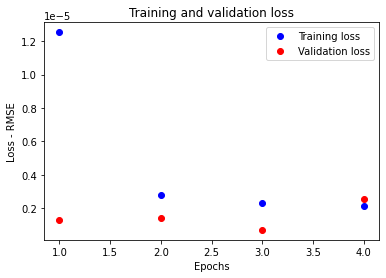

In [409]:
machine_stack = {}
if architecture_mode == 1:
    initialize_model(architecture)
elif architecture_mode == 2:
    for i in range(len(arch_keys)):
        initialize_model(architectures[arch_keys[i]])
machine_stack
machine_keys = list(machine_stack.keys())

## Loading a model doesn't work properly
When a model is loaded it doesn't predict in the same way it does as when the model is created in the same run as it is tested. 
This is apparently an issue for others as well: https://github.com/keras-team/keras/issues/4875
Thus far no working solution has been encountered, the workaraound would be to make sure the test results are obtained from the same run the model is trained in. This code below demonstrates that the weights are not the same when saved and loaded as they were initially. 
Likely causes:
Either keras uses randomness when initializing a model or there is some information which is lost when the model is converted to .JSON and .h5 and back. 

In [410]:
m1 = machine_stack[machine_keys[0]].model
m2 = load_model(machine_stack[machine_keys[0]].arch)
print(np.array_equal(m1.weights, m2.weights))
#print(m1.weights, m2.weights)
'''
for l1, l2 in zip(m1.layers, m2.layers):
    print(l1.get_config() == l2.get_config())
'''


 Loaded model:  MLPsame1_4
False


'\nfor l1, l2 in zip(m1.layers, m2.layers):\n    print(l1.get_config() == l2.get_config())\n'

# Plot a sample prediction
Showing a sample prediction made by the net we just trained.

In [166]:
def sample_prediction(self, series_stack, s):
    batch = 'batch2'
    series = series_stack['100%'][self.arch['preprocess_type']][batch].data#[self.arch['target_sensor']]
    start = s
    end = start+self.arch['n_pattern_steps']
    print(np.shape(series))
    x = np.reshape(
        np.array([np.array(series[:,start:end])]), 
        (1, self.arch['n_pattern_steps'], self.arch['features'])
        )
    prediction = self.model.predict(
        x,
        batch_size = 1,
        verbose = 1)
    ground_truth = series[0,end+1:end+1+self.arch['n_target_steps']]
    err = rmse_np(ground_truth, prediction)
    # Input
    plt.plot(np.linspace(start,end, self.arch['n_pattern_steps']),series[0,start:end])
    # Prediction
    plt.plot(np.linspace(end+1,end+1+self.arch['n_target_steps'],self.arch['n_target_steps']), prediction[0], 'r*')
    # Ground truth
    plt.plot(np.linspace(end+1,end+1+self.arch['n_target_steps'],self.arch['n_target_steps']), ground_truth,'ko')
    plt.legend(['Input', 'Prediction', 'Ground truth'])
    plt.title(self.arch['model']+', '+self.arch['normalization'])
    plt.xlabel('Timestep')
    plt.ylabel('Normalized acceleration')
    plt.text(
        x = start, 
        y = 0, 
        s = 'RMSE = ' + str(np.round(a = err[0], decimals = 4))
        )
    if save_plots == True:
        plt.savefig(self.arch['prediction_path']+self.arch['fname']+'_'+str(start)+'_'+batch+'_dataset'+str(self.arch['dataset'])+'.png')
    plt.show()
    return
NeuralNet.sample_prediction = sample_prediction
def generate_samples():
    for j in [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000,12500,13000,13500,14000,14500,15000,15500]:
        for i in range(len(machine_keys)):
            #NeuralNet.sample_prediction(machine_stack[machine_keys[i]], series_stack, j)
            pass
generate_samples()

# Evaluation
Method for evaluating a model. It requires the same arguments as the `train ` method. The returned `results` contains lists that are used to plot the results. The model score is defined as the Root mean square error for the model on a single series, and should in general be the same as the models' loss function. 

In [167]:
def batch_evaluation(self,stacks):
    stack = stacks[self.arch['preprocess_type']]
    scores = []
    speeds = []
    damage_states = []
    for i in range(len(stack)):
        key = 'batch'+str(i%len(stack))
        if stack[key].category == 'test':
            series = stack[key]
            patterns, targets = eval_generator(self, series)
            speed = stack[key].speed
            score = self.model.test_on_batch(
              patterns, 
              targets, 
              reset_metrics = False,
              return_dict = True
              )
            scores.extend([score[self.arch['metric']]])
            speeds.extend([speed])
            damage_states.extend([stack[key].damage_state])
    results = {
        'scores' : scores,
        'speeds' : speeds,
        'steps' : len(speeds[:]),
        'damage_state' : damage_states[:]
    }
    return results
def data_sequence(self, series): # obsolete
    patterns = np.empty([series.n_series, self.arch['n_pattern_steps'], self.arch['features']])
    targets = np.empty([series.n_series,self.arch['n_target_steps']])
    for j in range(len(self.arch['pattern_sensors'])):        
        for k in range(series.n_series):                
            pattern_indices = np.arange(k,k+(self.arch['delta'])*self.arch['n_pattern_steps'],self.arch['delta'])
            target_indices = k+self.arch['delta']*self.arch['n_pattern_steps']
            patterns[k,:,j] = series.data_dict[self.arch['normalization']][j][pattern_indices]
            if self.arch['pattern_sensors'][j] == self.arch['target_sensor']:
                targets[k,:] = series.data_dict[self.arch['normalization']][j][target_indices]
    return patterns, targets

In [168]:
 
def eval_generator(self, series):
    steps = get_steps(self, series)
    #print(steps)
    X = np.empty([steps,self.arch['n_pattern_steps'], self.arch['features']])
    Y = np.empty([steps,self.arch['n_target_steps']])
    for j in range(len(self.arch['pattern_sensors'])):     
        for k in range(steps):    
            pattern_start = k*self.arch['pattern_delta']
            pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
            target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
            target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
            X[k,:,j] = series.data_dict[self.arch['normalization']][j][pattern_start:pattern_finish]
            Y[k,:] = series.data_dict[self.arch['normalization']][j][target_start:target_finish]
    return X, Y
def evaluation(self, series_stack):
    scores = []
    speeds = []
    damage_states = []
    for i in range(len(series_stack[self.arch['preprocess_type']])):
        series = series_stack[self.arch['preprocess_type']]['batch'+str(i)]
        if series.category == 'test':
            X, Y = eval_generator(self, series)
            score = self.model.evaluate(
                x = X,
                y = Y,
                batch_size = self.arch['eval_batch_size'],
                verbose = 1,
                return_dict = True)
            speeds.extend([series.speed])
            scores.extend([score[self.arch['metric']]])
            damage_states.extend([series.damage_state])
        
    results = {
        'scores' : scores[:],
        'speeds' : speeds[:],
        'steps' : len(speeds[:]),
        'damage_state' : damage_states[:]
    }
    return results

In [169]:

if eval_mode == 1:
    NeuralNet.evaluation = evaluation
elif eval_mode == 2:
    NeuralNet.evaluation = batch_evaluation

# Performance plot
This function plots RMSE (y-axis) versus speed (x-axis), and colors the datapoints according to their damage state. This makes it easy to see if the model performs better on healthy or unhealthy data, or if there is no difference. 

In [170]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def plot_performance(score_stack, a, pod): # pod = prediction or forecast
    cmap = plt.cm.rainbow_r
    percentage_keys = list(score_stack)
    percentage_nums = [int(percentage_keys[i][0:-1]) for i in range(len(percentage_keys))]
    norm = colors.Normalize(vmin = min(percentage_nums), vmax = 100)
    
    for i in range(len(percentage_keys)): # Iterates over percentages
        for j in range(len(score_stack[percentage_keys[i]]['speeds'])):
            plt.plot(
                score_stack[percentage_keys[i]]['speeds'][j], 
                score_stack[percentage_keys[i]]['scores'][j], 
                color = cmap(norm(score_stack[percentage_keys[i]]['damage_state'][j])), 
                marker = 'X' if score_stack[percentage_keys[i]]['damage_state'][j] == 100 else 'o'
                )
    plt.xlabel('Speed [km/h]')
    plt.ylabel('Root Mean Square Error')
    plt.title('Sample scores for '+ a['model']+', '+a['normalization'], pad = 25.0)
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    cbar = plt.colorbar(sm)
    cbar.set_label('Young\'s modulus percentage', rotation=270)
    if save_plots == True:
        plt.savefig(fname = a['plot_path']+a['name']+'_performance_plot_dataset'+str(a['dataset'])+'batch_evaluation'+'.png')
    plt.show()


This piece of code creates a dictionary with the RMSE scores for all available damage states.

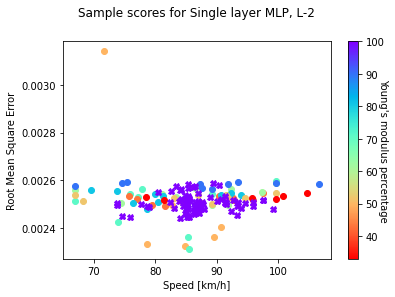

In [171]:

keys = list(series_stack)
score_stacks = {}
for i in range(len(arch_keys)):
    score_stack ={}
    for j in range(len(keys)):
        score_stack.update({
            keys[j] : NeuralNet.evaluation(machine_stack[machine_keys[i]], series_stack[keys[j]])
        })
    score_stacks.update({
        i : score_stack
    })

    if architecture_mode == 2:
        plot_performance(score_stack, architectures[arch_keys[i]], 'prediction')
    elif architecture_mode == 1:
        plot_performance(score_stack, architecture, 'prediction')


# Confusion Matrix
The function `get_binary_prediction` creates a confusion matrix. Firstly a distribution for the RMSE-values on healthy data is created, then the test data is compared to this distribution. If the probability of a series RMSE score is greater than 90 percent it is predicted to be healthy. 



In [172]:
import scipy.stats as stats
from scipy.stats import norm
import numpy.polynomial.polynomial as poly
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def get_binary_prediction(score_stack, arch):
    #arch.update({
    #    'z-score' : 2,
    #    'fitting_points' : 40})
    damage_cases = list(score_stack.keys())
    phi = np.empty(1)
    p = np.empty(1)
    labels = np.empty(1)
    unhealthy = np.empty(1)
    speeds = score_stack['100%']['speeds']
    healthy = score_stack['100%']['scores']
    indices = np.array(random.sample(range(len(healthy)), arch['fitting_points']))
    coefs = poly.polyfit(
        x = [speeds[i] for i in indices], 
        y = [healthy[i] for i in indices], 
        deg = arch['poly_deg'])
    ffit = poly.polyval(speeds, coefs)
    mu = np.mean(healthy)
    var = np.var(healthy)
    sigma = np.sqrt(var)
    #mu, std = stats.norm.fit(healthy)
    
    plot_positive_range(arch, speeds, healthy, coefs, mu, sigma, damage_cases, score_stack, indices)
    for i in range(len(damage_cases)):
        p = np.append(p,np.absolute(score_stack[damage_cases[i]]['scores'] - poly.polyval(score_stack[damage_cases[i]]['speeds'], coefs)), axis=0)
        phi = np.append(
            phi,
            stats.norm.cdf(np.absolute((score_stack[damage_cases[i]]['scores']-mu)/sigma)),
            axis = 0
            )
        if damage_cases[i] == '100%':
            labels = np.append(labels, np.zeros(len(score_stack[damage_cases[i]]['scores'])),axis=0)    
        else: 
            labels = np.append(labels, np.ones(len(score_stack[damage_cases[i]]['scores'])),axis=0)
            unhealthy = np.append(unhealthy, score_stack[damage_cases[i]]['scores'])
    plt.figure(
        num = None, 
        figsize=(8, 8), 
        dpi = 80, 
        facecolor = 'w', 
        edgecolor = 'k'
        )
    plot_pdf(healthy, bins = 8, color = 'g')
    plot_pdf(unhealthy, bins = 4, color = 'r')
    plt.show()
    poly_prediction = np.heaviside(p-arch['z-score']*sigma, 1)
    cdf_prediction = np.heaviside(phi - arch['probability_limit'], 1)
    prediction_dict = {
        'Phi' : phi[1:],
        'poly_prediction' : poly_prediction[1:],
        'cdf_prediction' : cdf_prediction[1:],
        'labels' : labels[1:]}
    prediction_dict.update({
        'poly_confusion_matrix' : confusion_matrix(prediction_dict['labels'],prediction_dict['poly_prediction']),
        'cdf_confusion_matrix' : confusion_matrix(prediction_dict['labels'],prediction_dict['cdf_prediction'])
        })
    return prediction_dict

## Histogram plot
Plots a histogram or several with the distribution of sample scores

In [173]:
def plot_pdf(data, bins, color): 
    mu, std = norm.fit(data)
    plt.hist(data, bins = bins, density = True, alpha=0.6, color = color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    #plt.show()

## Decision boundary plot
Plots all samples and the decision boundary

In [174]:
from matplotlib.lines import Line2D
def plot_positive_range(arch, speeds, healthy, coefs, mu, sigma, damage_cases, score_stack, indices):
    plt.figure(
        num = None, 
        figsize=(8, 8), 
        dpi = 80, 
        facecolor = 'w', 
        edgecolor = 'k'
        )
    plt.plot(speeds,healthy,'ro')
    for i in range(len(damage_cases)): # Loops over damage cases
        if damage_cases[i] == '100%': # Plots healthy samples not used to fit regression
            plt.plot(np.delete(arr = score_stack[damage_cases[i]]['speeds'], obj = indices), np.delete(arr = score_stack[damage_cases[i]]['scores'], obj = indices), 'yo')
        else: # Plots unhealty samples
            plt.plot(score_stack[damage_cases[i]]['speeds'], score_stack[damage_cases[i]]['scores'], 'k+')
    left, right = plt.xlim()
    base_x = np.linspace(left, right) # X-axis
    base_y = poly.polyval(base_x, coefs) # Polynomial approximation
    upper = sigma * arch['z-score'] # Upper decision boundary
    lower = -sigma * arch['z-score'] # Lower decision boundary
    plt.plot(base_x, base_y,'b')
    plt.plot(base_x, base_y + upper,'g')
    plt.plot(base_x, base_y + lower ,'g')
    plt.fill_between(base_x, base_y + lower, base_y + upper)
    custom_legend = [Line2D([0], [0], color = 'y', marker = 'o', linestyle = None),
                     Line2D([0], [0], color = 'r', marker = 'o', linestyle = None),
                     Line2D([0], [0], color = 'k', marker = '+', linestyle = None),
                     Line2D([0], [0], color = 'b'),
                     Line2D([0], [0], color = 'g')]
    plt.legend(custom_legend, ['Healthy samples', 'Healthy samples used to fit regression', 'Unhealthy samples', 'Regression line', 'Decision boundaries'])
    plt.xlabel('Speed')
    plt.ylabel('Errors')
    plt.title('Decision boundaries and samples')
    if save_plots == True:
        plt.savefig(fname = arch['plot_path'] + arch['name'] + 'decision_boundary' + '.png')
    plt.show()
    return

## Plotting the confusion matrix

In [175]:
import seaborn as sn
def plot_confusion(prediction, a):
    tempkeys = list(a['confusion_matrices'].keys())
    for i in range(len(a['confusion_matrices'])): # Loops over all confusion matrices
        data = np.array(prediction[tempkeys[i]+'_confusion_matrix'])
        text = np.asarray(
            [['True Negatives','False Positives'],
            ['False Negatives','True Positives']]
            )
        labels = (np.asarray(["{0}\n{1:.0f}".format(text,data) for text, data in zip(text.flatten(), data.flatten())])).reshape(2,2)
        sn.heatmap(
            prediction[tempkeys[i]+'_confusion_matrix'], 
            annot = labels,
            fmt='', 
            cbar = False,
            cmap = 'binary')
        plt.title(a['model']+', '+a['normalization']+' '+a['confusion_matrices'][tempkeys[i]])
        if save_plots == True:
            plt.savefig(fname = a['plot_path']+a['name']+'_'+tempkeys[i]+'_confusion_matrix_.png')
        plt.show()

Choses the appropriate architecture mode

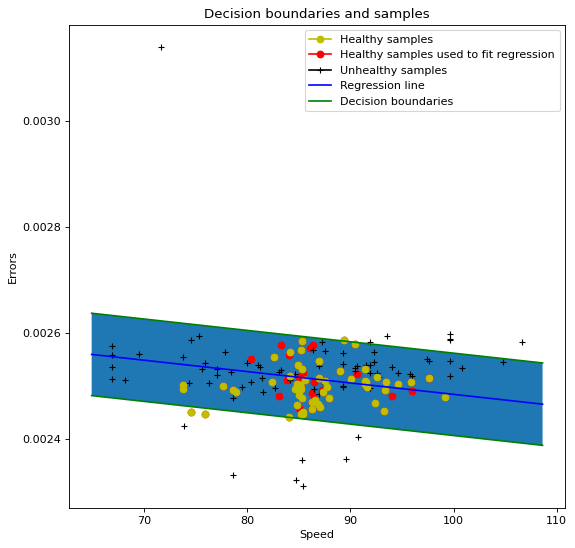

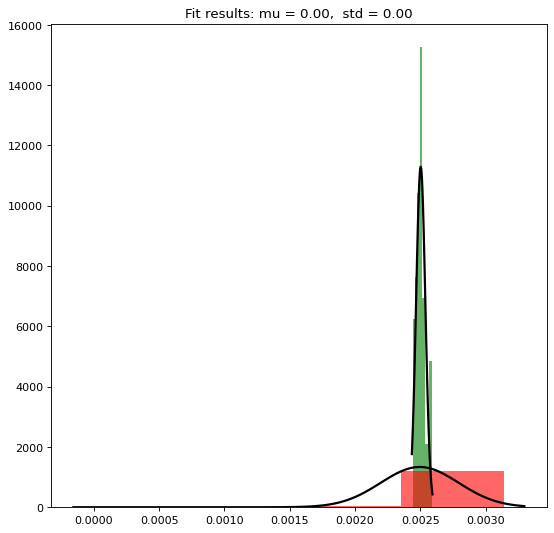

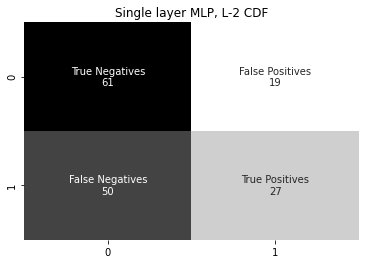

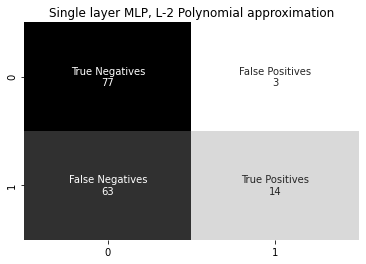

In [176]:

if architecture_mode == 2:

    for i in range(len(arch_keys)): # Loops over all models 
        binary_prediction = get_binary_prediction(score_stacks[i],architectures[arch_keys[i]])
        plot_confusion(binary_prediction,architectures[arch_keys[i]])
elif architecture_mode == 1:
        binary_forecast_prediction = get_binary_prediction(score_stack,architecture)
        plot_confusion(binary_forecast_prediction,architecture)

In [177]:
stats.zscore(architecture['probability_limit'])

IndexError: ignored

# Forecasting TBI
Method for creating a forecast. The Model makes a prediction on an input of size `'n_pattern_steps'`. This prediction is appended onto said input, the `'n_pattern_steps'` first steps are removed and the result is fed back into the model. After some steps the entire input consists of predicted values. This is of course a much more difficult task for the model than to just produce predictions. 

In [ ]:
#@title 
def forecast(machine, manual):
    # Shortcuts
    delta = machine.arch['delta']
    n_pattern_steps = machine.arch['n_pattern_steps']
    n_target_steps = machine.arch['n_target_steps']
    # Series
    key = 'batch'+str(manual['series']%len(manual['stack'][machine.arch['preprocess_type']]))
    n_steps = manual['stack'][machine.arch['preprocess_type']][key].n_steps
    series = manual['stack'][machine.arch['preprocess_type']][key]
    n_series = int((n_steps-n_pattern_steps)/n_target_steps)
    # Initial
    initial_indices = np.arange(0,delta*n_pattern_steps,delta)
    patterns = {}
    for i in range(len(machine.arch['pattern_sensors'])):
        patterns.update({ 
        'accel_input_'+machine.arch['pattern_sensors'][i] : 
            np.reshape(
                series.data_dict[self.arch['normalization']][machine.sensor_to_predict][initial_indices], 
                [1,machine.arch['n_pattern_steps']]
            )
        })
    forecasts = patterns.copy()
    evaluation = {}
    for i in range(n_series+1):
        old_patterns = patterns.copy()
        for j in range(len(machine.arch['pattern_sensors'])):
            prediction = machine.model.predict(
                old_patterns,
                batch_size = 1, 
                verbose=0,
                steps = 1) # Make prediction with machine
            pattern = patterns['accel_input_'+machine.arch['pattern_sensors'][j]] # Extract pattern
            pattern = np.delete(pattern,np.s_[0:n_target_steps:delta],1) # Remove first entty
            pattern = np.hstack([pattern,prediction]) # Add prediciton last
            patterns.update({
                'accel_input_'+machine.arch['pattern_sensors'][j] : pattern
                }) # Update patterns dict
            forecast = forecasts['accel_input_'+machine.arch['pattern_sensors'][j]] #Extract forecast
            if i == n_series: # Edge case for last bit                   
                forecast = np.hstack(
                    [forecast,
                    prediction[:,:n_steps%(n_series*n_target_steps+n_pattern_steps)]]
                    ) # Update forecast
            else:
                forecast = np.hstack([forecast,prediction]) # Update forecast
            forecasts.update({
                'accel_input_'+machine.arch['pattern_sensors'][j] : forecast
                }) # Update forecasts dict
    score = rmse_np(
        series.data[j][n_pattern_steps:], 
        forecasts['accel_input_'+machine.arch['pattern_sensors'][j]][0][n_pattern_steps:])
    speed = series.speed
    damage_state = series.damage_state
    return forecasts, (score, speed, damage_state)
NeuralNet.forecast = forecast

In [ ]:
#@title 
def plot_forecast(forecast, manual, a, image):
    key = 'batch'+str(manual['series'])
    print(key)
    forecast_keys = list(forecast.keys())
    plt.figure(
    num = None, 
        figsize=(16, 12), 
        dpi = 80, 
        facecolor = 'w', 
        edgecolor = 'k'
        )
    plt.plot(
        manual['stack'][a['preprocess_type']][key].timesteps, 
        forecast[forecast_keys[0]][0], 
        'b', 
        linewidth=0.2)
    plt.plot(
        manual['stack'][a['preprocess_type']][key].timesteps, 
        manual['stack'][a['preprocess_type']][key].data[a['sensors'][a['target_sensor']]], 
        'r', 
        linewidth=0.2)
    plt.xlabel('timesteps')
    plt.ylabel('accelerations')
    #plt.title('Forecast for response at '+str(manual['stack'][a['preprocess_type']][key].speed+' km/h'))
    plt.legend(['Forecast', 'Signals']) 
    if save_plots == True:
        plt.savefig(fname = a['prediction_path']+a['name']+'_series_'+str(manual['series'])+'_forecast_plot'+str(image)+'.png')
    plt.show() 

Print the prediction on the specified series. 

In [ ]:
#@title
prediction_manual = {
    'series' : 1,
    'stack' : series_stack['100%']
}
def predict(machine_stack, arch, prediction_manual):
    a_forecast, tup = forecast(machine_stack[architecture['fname']], prediction_manual)
    a_forecast
    plot_forecast(a_forecast, prediction_manual, architecture, image)
    image += 1

In [ ]:
training_manual = {
    'series' : 2,
    'stack' : series_stack['100%']
}
def prediction_train(self, training_manual):
    a_forecast, tup = NeuralNet.forecast(machine_stack, training_manual)
    X = np.empty([0,self.arch['n_pattern_steps']])#,len(self.arch['pattern_sensors'])])
    Y = np.empty([0,self.arch['n_target_steps']])
    series = training_manual['stack'][self.arch['preprocess_type']]['batch'+str(training_manual['series'])]
    steps = get_steps(self, series)
    x = np.empty([steps,self.arch['n_pattern_steps']])#, len(self.arch['pattern_sensors'])])
    y = np.empty([steps,self.arch['n_target_steps']])
    for j in range(len(self.arch['pattern_sensors'])):     
        for k in range(steps):    
            pattern_start = k*self.arch['pattern_delta']
            pattern_finish = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps']
            target_start = k*self.arch['pattern_delta']+self.arch['delta']*self.arch['n_pattern_steps'] # +1?
            target_finish = k*self.arch['pattern_delta']+self.arch['delta']*(self.arch['n_pattern_steps']+self.arch['n_target_steps'])
            x[k,:] = a_forecast['accel_input_'+self.arch['pattern_sensors'][j]][0][pattern_start:pattern_finish]
            y[k,:] = series.data_dict[self.arch['normalization']][j][target_start:target_finish]
    X = np.append(X,x,axis=0)
    Y = np.append(Y,y,axis=0)

    self.model.fit(
        x = X,
        y = Y,
        batch_size = self.arch['batch_size'],
        epochs = self.arch['epochs'], 
        verbose = 1,
        callbacks = self.early_stopping, #self.learning_rate_scheduler],
        validation_split = self.arch['data_split']['validation']/100,
        shuffle = False
        )
#NeuralNet.prediction_train = prediction_train
#NeuralNet.prediction_train(machine_stack[name], training_manual)

Similarly to how the `evaluation` function evaluate each data series on the predictions made on that series

In [ ]:
prediction_score = {}
prediction_training = {}
def forecast():
    for i in range(len(keys)):
        #print(series_stack[keys[i]])
        scores = []
        speeds = []
        damage_states = []
        for j in range(len(series_stack[keys[i]][architecture['preprocess_type']])):
            if series_stack[keys[i]][architecture['preprocess_type']]['batch'+str(j)].category == 'test':
                prediction_manual = {
                    'series_to_predict' : j,
                    'stack' : series_stack[keys[i]]
                }
                #prediction = NeuralNet.prediction(machine_stack[name], prediction_manual)
                #plot_prediction(prediction, prediction_manual, use)
                forecast, tup = NeuralNet.forecast(machine_stack, prediction_manual)
                scores.extend([tup[0]])
                speeds.extend([tup[1]])
                damage_states.extend([tup[2]])
            else:
                continue
        prediction_score.update({
            keys[i] : {'scores' : scores, 'speeds' : speeds, 'damage_state' : damage_states}           
            })

In [ ]:
#plot_performance(prediction_score,architecture,'forecast')

In [ ]:
#binary_forecast_prediction = get_binary_prediction(prediction_score,architecture)
#plot_confusion(binary_forecast_prediction,name,'forecast')